### time-series
* track/sliding/test window size: 57435, 34452, 11484
* walk-forward validation

In [27]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 25)
(709325, 22)


In [28]:
pp = Preprocess(df_transaction, df_property)
use_features = pp.get_feature_list()
use_features

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat']

In [7]:
# records of last 2 years
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(68919, 14)

In [8]:
monthly_volume = int(df_track.shape[0] / 24)
df_track.head()

,sqft_price_zip_avg,sqft,sold_price_zip_avg,num_bed,num_bath,date,view,sold_price,pool,sqft_zip_avg,impr_over_land,lat,id,lon
0,334.725439,1064,698046.052632,2.0,2.0,2015-10-01,0,346500,0,2162.542982,1.015708,32.93745,1428580,-117.10164
50286,257.919540,1277,282327.586207,2.0,1.0,2015-10-01,0,400000,0,1113.244663,0.639538,32.74247,1428633,-117.07549
50287,257.919540,1366,282327.586207,2.0,2.0,2015-10-01,0,418000,0,1113.244663,1.055773,32.72620,1428641,-117.08364
51748,246.869369,1459,354269.144144,3.0,2.0,2015-10-01,0,417500,0,1483.899399,0.967124,32.62687,1428713,-117.05104
51747,246.869369,814,354269.144144,2.0,1.0,2015-10-01,0,175000,0,1483.899399,1.357232,32.61402,1428664,-117.08126


### LinearRegression

In [9]:
# walk-forward validation
# K-fold cross validation
from sklearn.linear_model import Ridge
rr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ElasticNet(random_state=42))
     ])
parameters = {'clf__l1_ratio': [0.05, 0.07, 0.1, 0.12, 0.14],
              'clf__alpha': [0.01, 0.03, 0.05, 0.07, 0.09]}

mm = ModelManager(df_track, use_features, rr, time_series=True)
mm.run(param_grid=parameters, GridSearchCV={'verbose':True, 'n_jobs':-1}, sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57435, 34452, 11484
[dp] train/valid/test size: 45948, 11487, 11484
[dp] walk-forward train:(11487,), test:(11487,)
[dp] walk-forward train:(22974,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] 4-fold walk-forward validation
[dp] track_window:57435, sliding_window:34452, test_window:11484


Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished


174470.50116865447

In [10]:
mm.summary()

[dp] best params: {'clf__alpha': 0.01, 'clf__l1_ratio': 0.14}
[dp] best score: -29844986631.50293
[dp] cv results:
{'mean_fit_time': array([0.3183704 , 0.40971345, 0.48315954, 0.48240733, 0.46949852,
       0.28914487, 0.30393308, 0.33514094, 0.47726923, 0.36284024,
       0.28789043, 0.3679775 , 0.24853623, 0.31609064, 0.3580749 ,
       0.17559445, 0.14325649, 0.13536012, 0.13097346, 0.14112568,
       0.12332773, 0.12007082, 0.11154747, 0.12708819, 0.08472508]),
 'mean_score_time': array([0.00250494, 0.00388569, 0.00300866, 0.00313342, 0.00376028,
       0.00338328, 0.00325924, 0.00476354, 0.00288272, 0.0036338 ,
       0.00300837, 0.00438607, 0.00376076, 0.00376362, 0.00338447,
       0.00325704, 0.00288218, 0.00325888, 0.00325996, 0.00288326,
       0.00288332, 0.00300729, 0.0028829 , 0.0030089 , 0.00225669]),
 'mean_test_score': array([-2.98502864e+10, -2.98491012e+10, -2.98473313e+10, -2.98461568e+10,
       -2.98449866e+10, -2.99819182e+10, -2.99771946e+10, -2.99701757e+10,
   

[dp] training error: 174018.3466419959
[dp] testing error: 174470.50116865447


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [11]:
ntrees = np.arange(20,110,40)
depths = np.arange(7,15)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}
rf = RandomForestRegressor(n_jobs=-1, random_state=17)

mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(param_grid=parameters, sliding_window=monthly_volume*12, test_size=monthly_volume*4, GridSearchCV={'verbose':True, 'n_jobs':-1})

[dp] track/sliding/test window size: 57435, 34452, 11484
[dp] train/valid/test size: 45948, 11487, 11484
[dp] walk-forward train:(11487,), test:(11487,)
[dp] walk-forward train:(22974,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] 4-fold walk-forward validation
[dp] track_window:57435, sliding_window:34452, test_window:11484


Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.7min finished


128469.58336620341

In [12]:
mm.summary()

[dp] best params: {'max_depth': 14, 'n_estimators': 60}
[dp] best score: -16101741905.077374
[dp] cv results:
{'mean_fit_time': array([0.71270615, 2.90997261, 4.79512185, 1.94830477, 3.58791339,
       5.60001165, 1.7849952 , 3.27746147, 5.93640584, 2.23807436,
       4.17622542, 7.42310792, 2.32643443, 4.93274206, 6.66108251,
       2.50904483, 4.95605004, 8.09965646, 2.47182047, 4.91080397,
       9.38494742, 2.95034295, 6.81674653, 8.47590655]),
 'mean_score_time': array([0.30476284, 0.55560231, 0.7109164 , 0.62992448, 0.64158034,
       0.7260555 , 0.66138327, 0.49118114, 1.00266546, 0.79737025,
       0.92533559, 0.89074308, 0.8354708 , 0.54770219, 0.48516506,
       1.06094545, 0.86191618, 0.83960754, 0.75137329, 0.97734833,
       1.36650795, 1.04101765, 1.18151546, 0.64859951]),
 'mean_test_score': array([-1.94533285e+10, -1.92808129e+10, -1.92543434e+10, -1.85209485e+10,
       -1.82797146e+10, -1.82607124e+10, -1.77930427e+10, -1.74714670e+10,
       -1.74585153e+10, -1.72429

[dp] training error: 94319.45605972147
[dp] testing error: 128469.58336620341


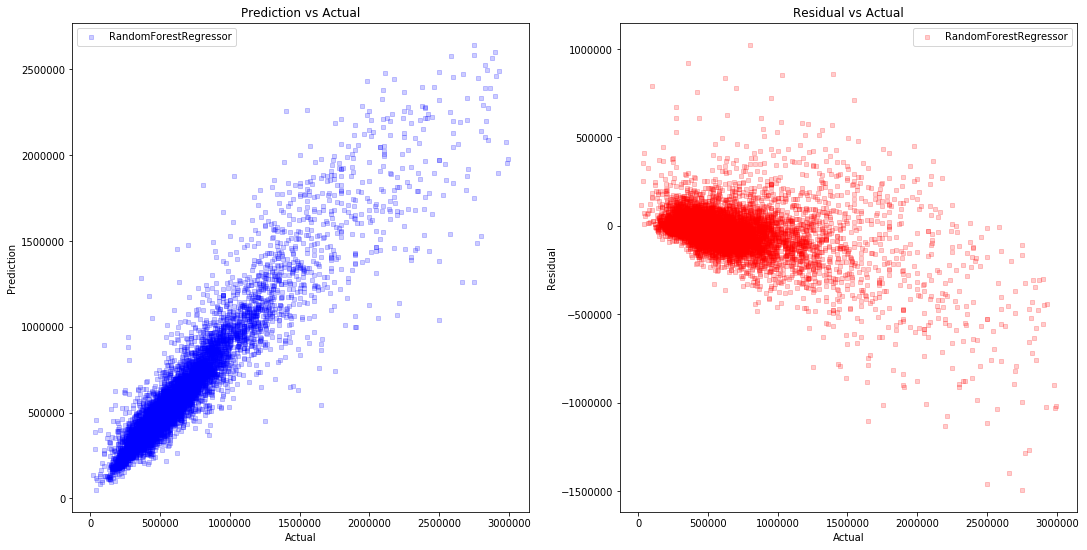

In [13]:
mm.plot_residual()

C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


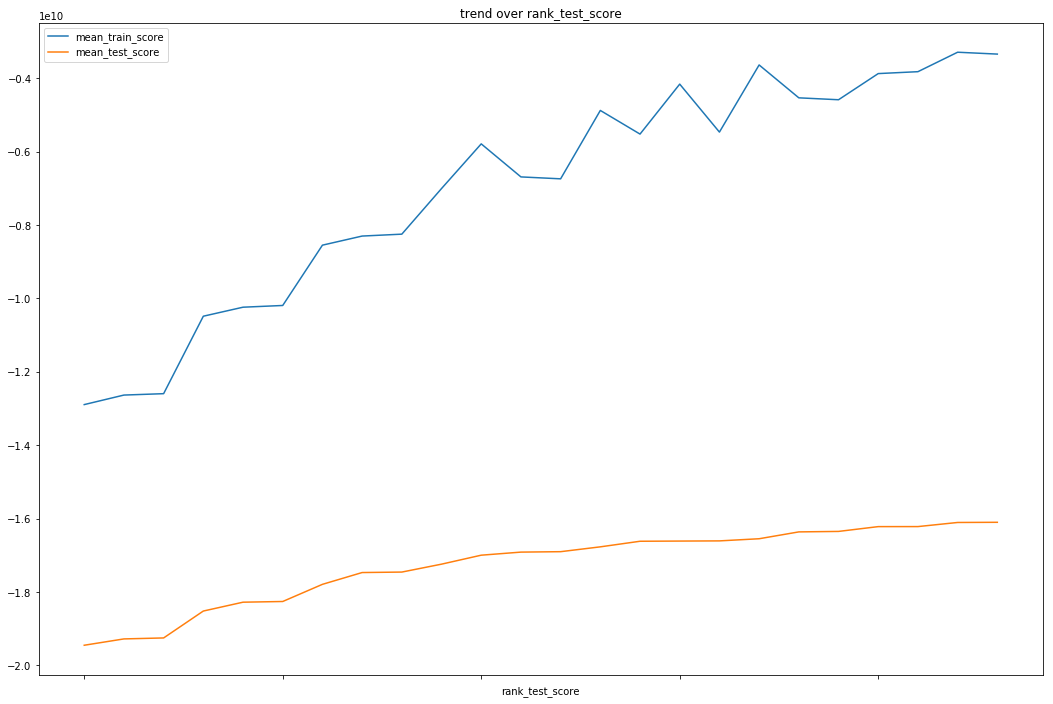

[{'max_depth': 7, 'n_estimators': 20},
 {'max_depth': 7, 'n_estimators': 60},
 {'max_depth': 7, 'n_estimators': 100},
 {'max_depth': 8, 'n_estimators': 20},
 {'max_depth': 8, 'n_estimators': 60},
 {'max_depth': 8, 'n_estimators': 100},
 {'max_depth': 9, 'n_estimators': 20},
 {'max_depth': 9, 'n_estimators': 60},
 {'max_depth': 9, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 20},
 {'max_depth': 11, 'n_estimators': 20},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 60},
 {'max_depth': 12, 'n_estimators': 20},
 {'max_depth': 11, 'n_estimators': 60},
 {'max_depth': 13, 'n_estimators': 20},
 {'max_depth': 11, 'n_estimators': 100},
 {'max_depth': 14, 'n_estimators': 20},
 {'max_depth': 12, 'n_estimators': 100},
 {'max_depth': 12, 'n_estimators': 60},
 {'max_depth': 13, 'n_estimators': 60},
 {'max_depth': 13, 'n_estimators': 100},
 {'max_depth': 14, 'n_estimators': 100},
 {'max_depth': 14, 'n_estimators': 60}]

In [14]:
mm.plot_learning_curve()

### residual analysis
* check distribution of residual
* scatter plot of residual and attributes: sqrt, lon, lat to see any correlation

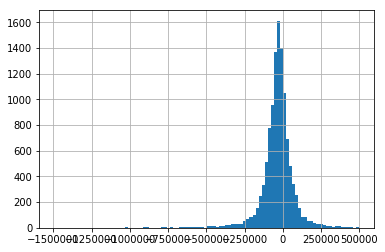

In [29]:
df_check = pp.debug(mm.get_result_df())
df_check[df_check['residual']<500000]['residual'].hist(bins=100)

In [24]:
df_check.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\baseline_residual.csv')

Text(0.5,1,'sold_price vs residual')

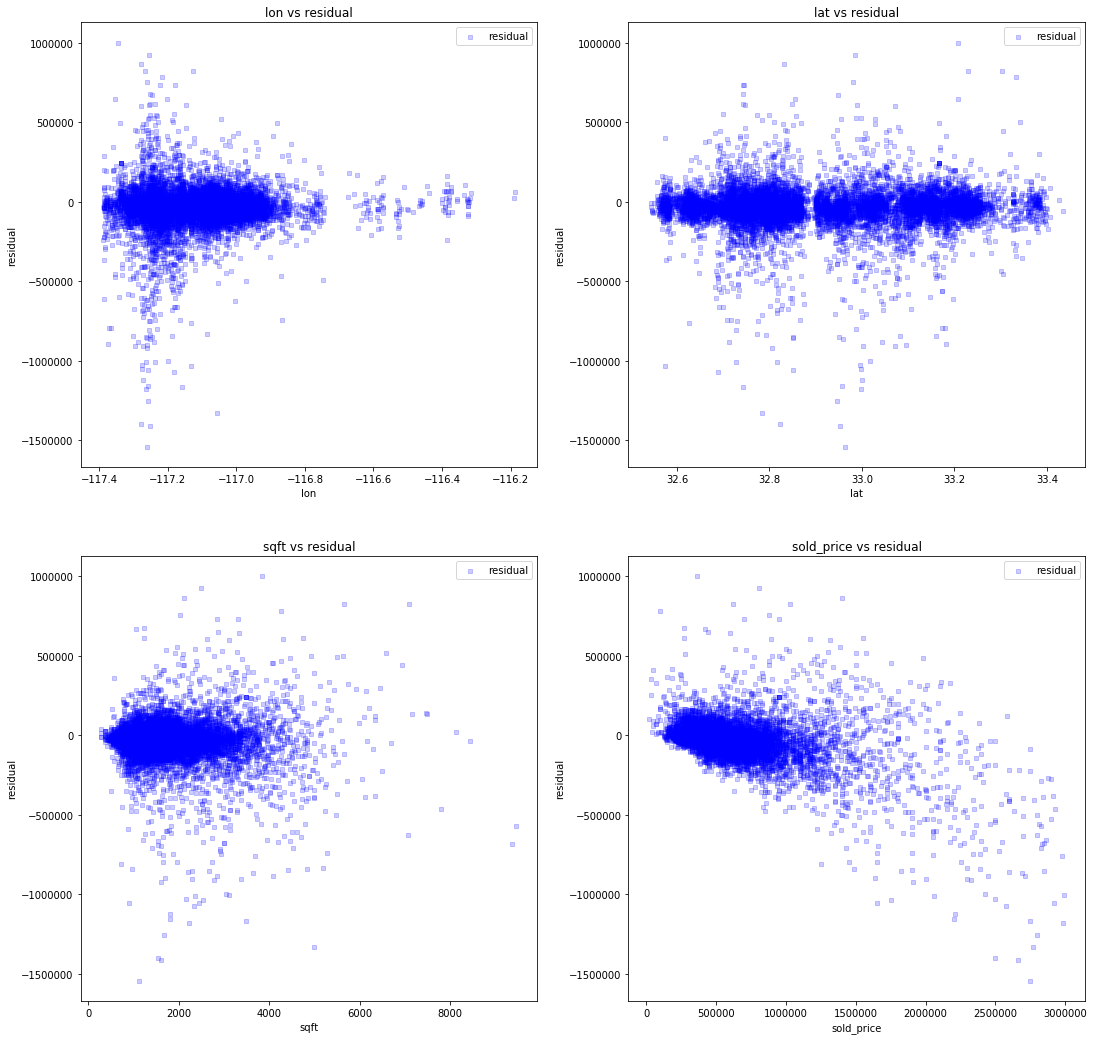

In [33]:
fig = plt.figure(figsize=(18, 18))
ax1 = fig.add_subplot(221)
ax1.scatter(df_check['lon'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('lon')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('lon vs residual')

ax1 = fig.add_subplot(222)
ax1.scatter(df_check['lat'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('lat')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('lat vs residual')

ax1 = fig.add_subplot(223)
ax1.scatter(df_check['sqft'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('sqft')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('sqft vs residual')

ax1 = fig.add_subplot(224)
ax1.scatter(df_check['sold_price'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('sold_price')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('sold_price vs residual')

In [20]:
def remeasure(df_check, threshold=200000):
    removed = df_check[df_check['residual']>=threshold]
    print("removed records:", removed.shape[0])
    df_left = df_check[df_check['residual']<threshold]
    return sqrt(mean_squared_error(df_left['predict'], df_left['sold_price']))

remeasure(df_check)

removed records: 231


118791.39933910602

In [20]:
df_check[(df_check['residual']>=600000)]

,str_no,street,st_type,city,zip,lon,lat,sqft,sold_price,predict,residual,date,pin,land_use_subcode
2125,256,NAUTILUS,ST,LA JOLLA,92037,-117.27954,32.83124,2112,1400000,2.204266e+06,804265.569231,2017-06-28,3512706402,17
3488,3636,CURTIS,ST,SAN DIEGO,92106,-117.22378,32.74331,3318,700000,1.444355e+06,744354.980363,2017-07-11,4496701800,11
4489,839,IDA,AVE,SOLANA BEACH,92075,-117.25607,32.98449,2487,805000,1.739380e+06,934380.304806,2017-07-20,2982832600,11
5967,4955,DEL MONTE,AVE,SAN DIEGO,92107,-117.25253,32.74377,1234,271000,8.990516e+05,628051.587407,2017-08-01,4481713202,17
6721,4955,DEL MONTE,AVE,SAN DIEGO,92107,-117.25253,32.74377,1234,271000,9.683763e+05,697376.301031,2017-08-09,4481713204,17
7911,3198,CAMINO PORTOFINO,None,FALLBROOK,92028,-117.21636,33.33365,4268,100000,8.989720e+05,798972.035143,2017-08-21,1240410800,11
7916,169,PARNASSUS,CIR,OCEANSIDE,92054,-117.34536,33.20757,3848,361000,1.256497e+06,895497.175926,2017-08-22,1491001900,11
8638,9765,LITTLE CANYON,LN,ESCONDIDO,92026,-117.12678,33.23000,7100,1030000,1.877090e+06,847090.000000,2017-08-29,1854132300,11
8938,7929,AVENIDA KIRJAH,None,LA JOLLA,92037,-117.23771,32.84985,4757,1550000,2.323232e+06,773231.852642,2017-08-31,3467323300,11
9138,4912,CONEJO,RD,FALLBROOK,92028,-117.26664,33.30373,5659,620000,1.462975e+06,842974.666667,2017-08-31,1211210600,11
